In [14]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as spy
from tqdm import tqdm
import time
import pickle


# 결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'

pd.set_option('display.max_rows',200)
pd.set_option('display.max_colwidth',None)

from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

# generate and save XGB_fti_matrix_icd.pickle by processing XGB_res_icd.pickle

In [15]:
# ICD_VER=9

# with open('./xgb_results/XGB_res_icd{}.pickle'.format(ICD_VER), 'rb') as f:
#     xgb_res_df=pickle.load(f)

# ftn_all=[]
# for ftn in xgb_res_df['FTN']:
#     ftn_all+=ftn
# ftn_all=list(set(ftn_all))
# fti_df=pd.DataFrame(columns=['group','APR','AUC']+ftn_all)
# fti_df

# for ii, row in xgb_res_df.iterrows():
#     hage1, hage2, apr, auc, ftn, fti=row
    
#     gp='[{}-{})'.format(hage1, hage2)
    
#     fti_sr=pd.Series(index=ftn, data=fti)
#     fti_sr.loc['group']=gp
#     fti_sr.loc['APR']=apr
#     fti_sr.loc['AUC']=auc
    
#     fti_df.loc[ii]=fti_sr
# fti_df

# with open('./xgb_results/XGB_fti_matrix_icd{}.pickle'.format(ICD_VER), 'wb') as f:
#     pickle.dump(fti_df, f)

In [16]:
L2S={'Hypertensive chronic kidney disease with stage 1 through stage 4 chronic kidney disease':
     'Hypertensive chronic kidney disease',
     'Personal history of other venous thrombosis and embolism':
     'history of other venous thrombosis',
     'Presence of coronary angioplasty implant and graft':
     'Presence of coronary angioplasty implant',
     'Atherosclerotic heart disease of native coronary artery without angina pectoris':'Atherosclerotic disease',
     'Long term (current) use of antithrombotics/antiplatelets':'Long term use of antithrombotics',
     'Long term (current) use of anticoagulants':'Long term use of antithrombotics',
     'Hypertrophy (benign) of prostate without urinary obstruction and other lower urinary tract symptom (LUTS)':
     'Hypertrophy of prostate w/o urinary obstruction',
     'Type 2 diabetes mellitus with diabetic peripheral angiopathy without gangrene':
     'Type 2 diabetes with diabetic peripheral angiopathy',
     'Adverse effect of antineoplastic and immunosuppressive drugs': 'Adverse effect of antineoplastic drugs',
     'Personal history of venous thrombosis and embolism':'History of venous thrombosis',
     'Coronary atherosclerosis of native coronary artery':'Coronary atherosclerosis of artery',
     'Coronary atherosclerosis of unspecified type of vessel':'Coronary atherosclerosis of vessel',
     'Chronic hepatitis C without mention of hepatic coma': 'Chronic hepatitis C w/o hepatic coma',
     'Percutaneous transluminal coronary angioplasty status': 'Percutaneous coronary angioplasty',
     'Unspecified dementia without behavioral disturbance':'Dementia w/o behavioral disturbance',
     'Non-ST elevation (NSTEMI) myocardial infarction': 'NSTEMI myocardial infarction',
     'Personal history of transient ischemic attack (TIA)': 'History of ischemic attack',
     'Benign prostatic hyperplasia without lower urinary tract symptoms': 'Benign prostatic hyperplasia',
     'Diabetes mellitus due to underlying condition with diabetic polyneuropathy': 'Diabetes with neuropathy',
     'Age-related osteoporosis without current pathological fracture': 'osteoporosis w/o pathological fracture',
     'Morbid (severe) obesity due to excess calories': 'obesity due to excess calories',
     'Presence of unspecified artificial hip joint': 'Presence of artificial hip joint',
     'Personal history of nicotine dependence': 'history of nicotine dependence',
     'Type 2 diabetes mellitus without complications': 'Type 2 diabetes w/o complications',
     'Obstructive sleep apnea (adult) (pediatric)': 'Obstructive sleep apnea',
     'Personal history of malignant neoplasm of breast':'Personal history of breast cancer',
     'Long term (current) use of antithrombotics/antiplatelets': 'Long term use of antithrombotics',
     'Gastro-esophageal reflux disease without esophagitis':'Gastro-esophageal reflux disease'}

def shorten_icd_name(n1):
    n2=n1.split(',')[0]
    
    if n2 in L2S.keys():
        n3=L2S[n2]
    else:
        n3=n2
    return n3.replace('without','w/o')

def get_sig_val(x):
    if x!=x:
        return np.nan
    if x<fti_sig_th:
        return np.nan
    return x

# plot heatmap presenting predictive factors identified by XGBoost

In [18]:
icd9_to_10=pd.read_table("tables/icd9_to_icd10_conversion.txt", sep='\t', index_col=0)
icd9_to_10['icd10']=icd9_to_10['icd10'].map(lambda x: x.replace('.',''))
icd9_to_10.loc['4241']='I350'
icd9_to_10.loc['2724']='E785'
icd9_to_10

,icd10
icd9,
42731,I4891
V4581,Z951
41401,I2510
4241,I350
41400,I2510
412,I252
V4582,Z9861
V5861,Z7901
3572,"E0842,E0942,E1042,E1142,E1342"


In [ ]:
   ##### for save file
    xgb_res_supple_mat_save=fti_mean_sig_df.copy()
    xgb_res_supple_mat_save.reset_index(inplace=True)
    xgb_res_supple_mat_save.rename(columns={'index':'ICD-{}'.format(ICD_VER)}, inplace=True)

    if ICD_VER==9:
        xgb_res_supple_mat_save['ICD-10']=xgb_res_supple_mat_save['ICD-9'].replace(icd9_to_10['icd10'])
        xgb_res_supple_mat_save['ICD-10']=xgb_res_supple_mat_save['ICD-10'].map(lambda x: x.split(',')[0])
        
    xgb_res_supple_mat_save['long_title (ICD-10)']=xgb_res_supple_mat_save['ICD-10'].replace(d_icd10['long_title'])
    xgb_res_supple_mat_save.to_csv('tables/chi2_res_icd{}_rev.txt'.format(ICD_VER), sep='\t')
     ##### for save file

<AxesSubplot:xlabel='group', ylabel='AUC'>

<AxesSubplot:xlabel='group', ylabel='AUC'>

(49, 9)

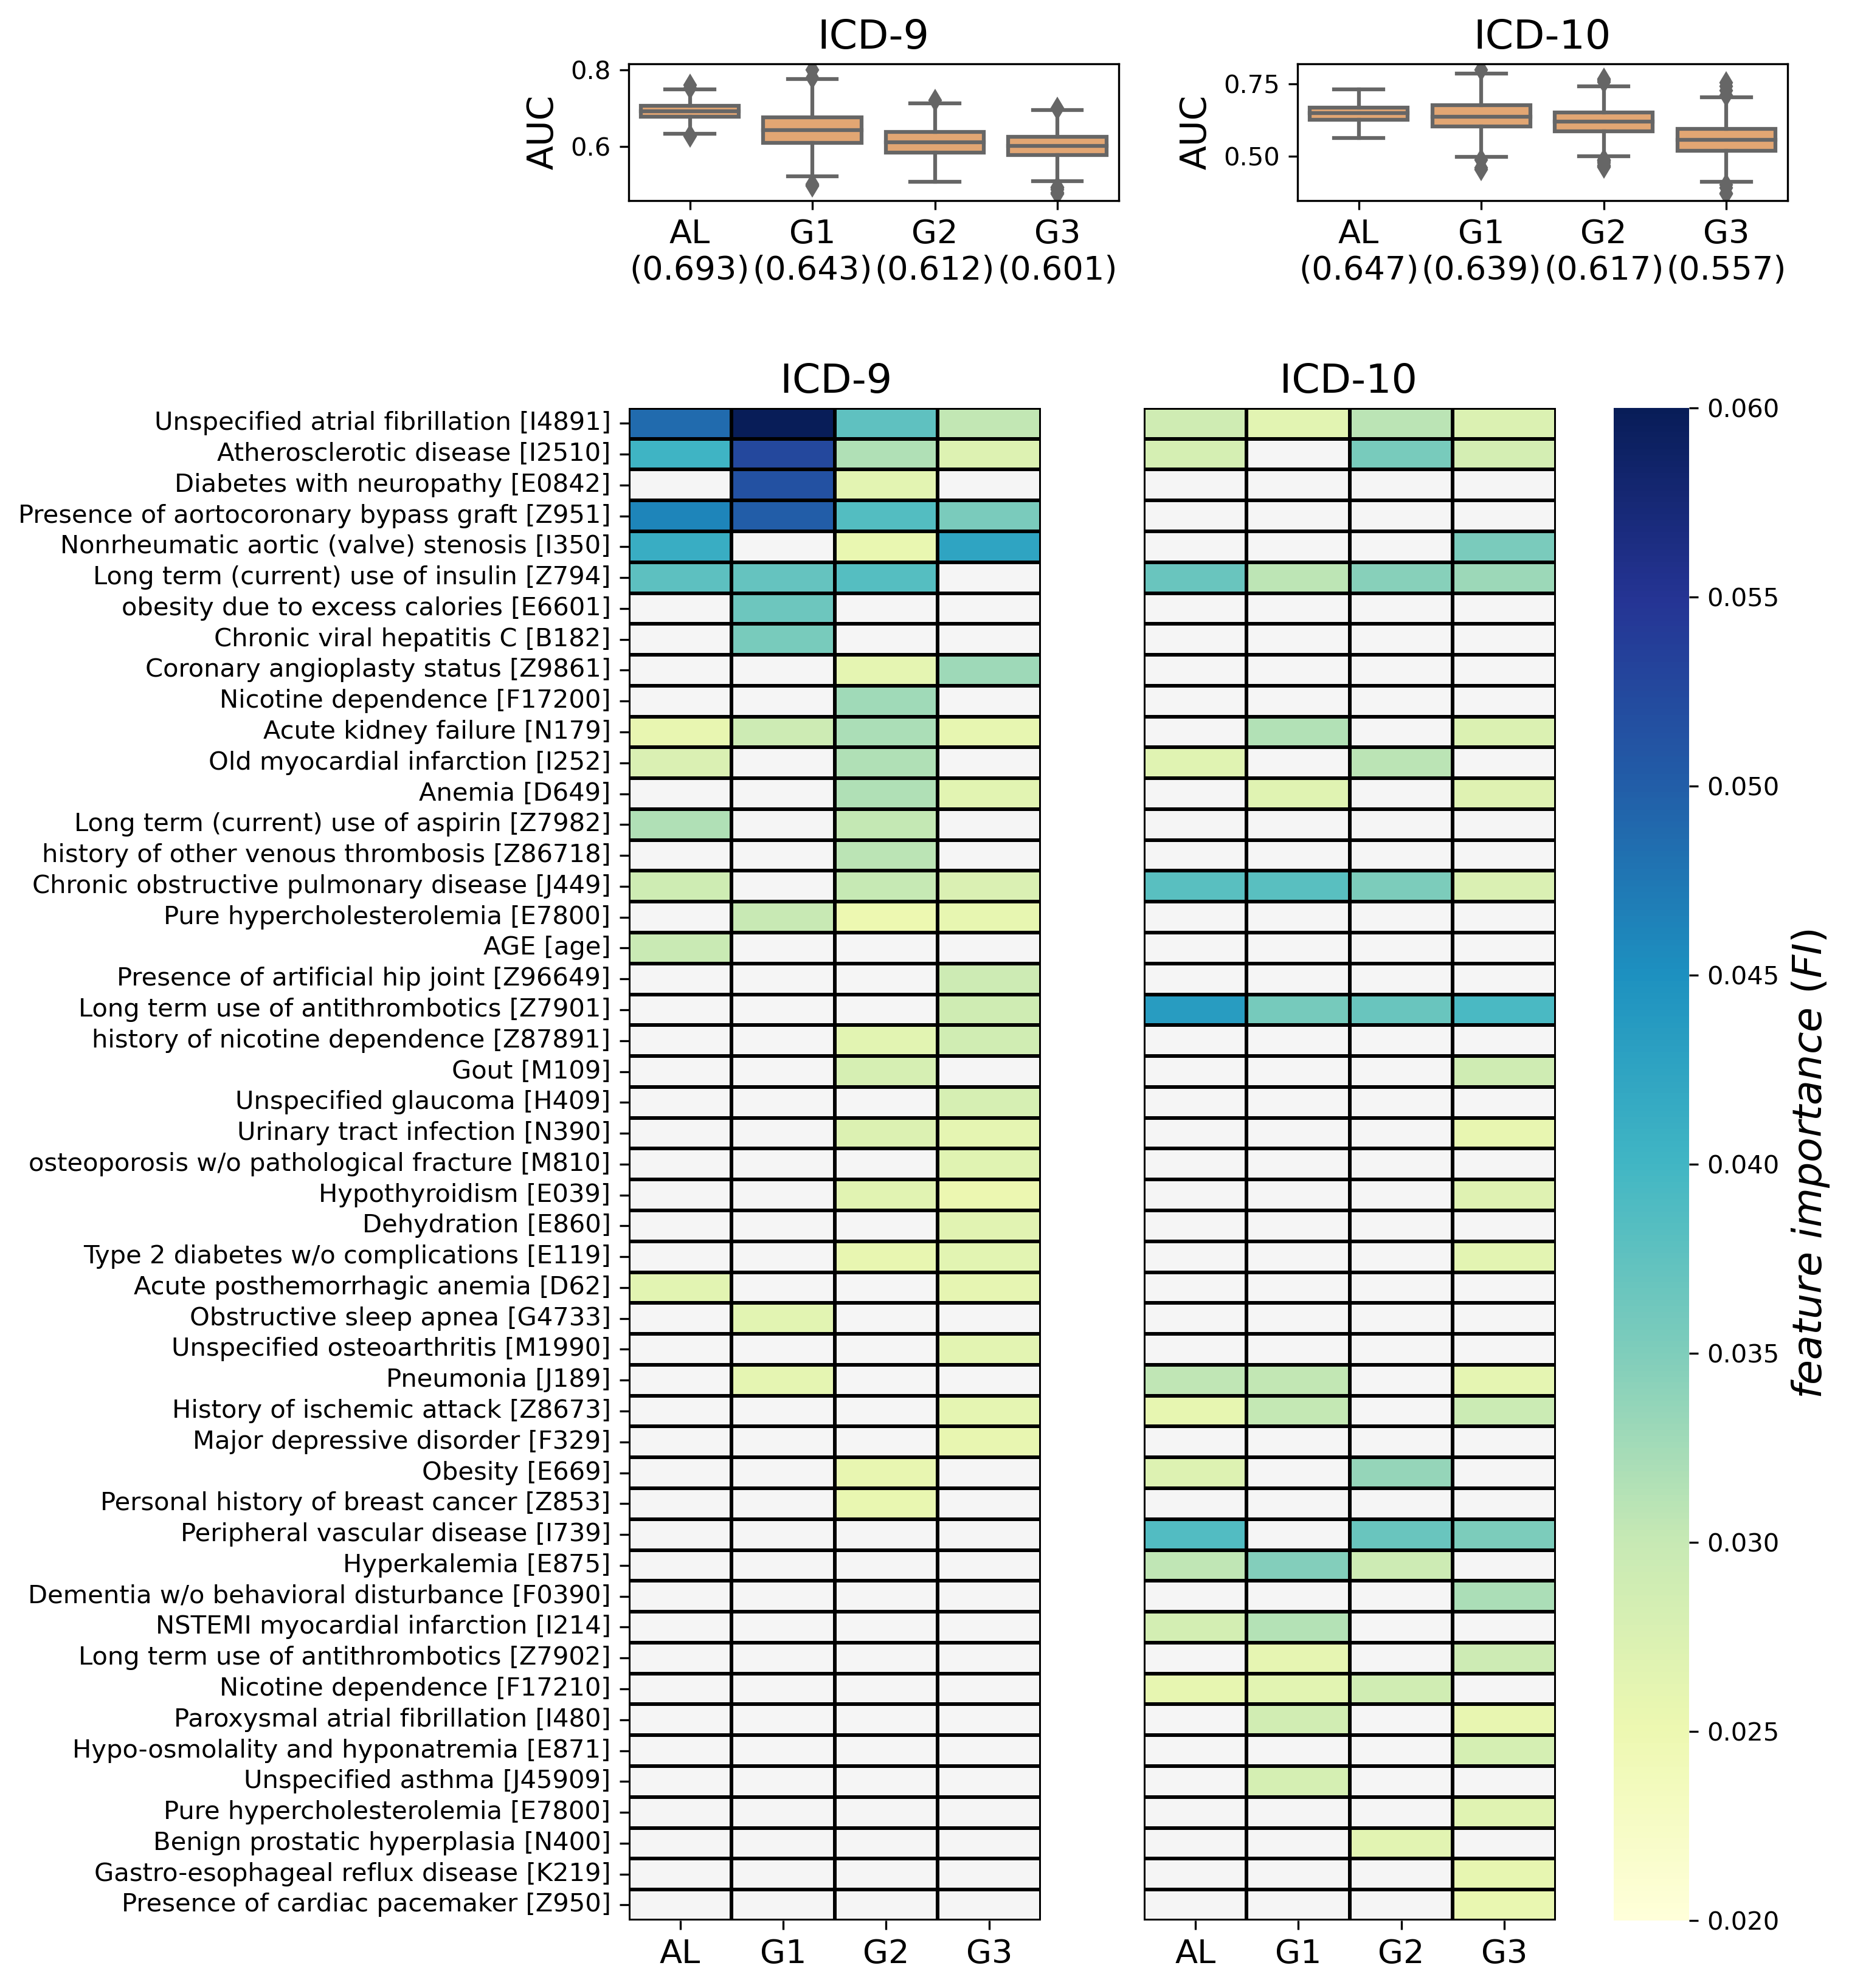

In [24]:
from matplotlib.patches import Rectangle

fti_sig_th=0.0251

##
fig=plt.figure(figsize=(10,11), dpi=300)
ax_a=fig.add_subplot(6,2,1)
ax_b=fig.add_subplot(6,2,2)
ax_c=fig.add_subplot(6,2,(3,12))

xgb_res_sig_both=pd.DataFrame()
for ax1, ICD_VER in zip([ax_a,ax_b], [9,10]):
    ###
    d_icd=pd.read_table("/data/mimic-iv-0.4/hosp/d_icd_diagnoses.csv", sep=',', index_col=0)
    d_icd.index=d_icd.index.str.strip()
    d_icd.loc['gender']=[ICD_VER, 'GENDER']
    d_icd.loc['age']=[ICD_VER, 'AGE']
    
    d_icd10=d_icd.loc[d_icd['icd_version']==10]
        
    ###
    with open('./xgb_results/XGB_fti_matrix_icd{}.pickle'.format(ICD_VER), 'rb') as f:
        fti_df=pickle.load(f)

    fti_df['group']=fti_df['group'].replace({'[0-120)': 'AL', '[0-65)': 'G1', '[65-80)': 'G2', '[80-120)': 'G3'})
    
    ########## AUC boxplot
    sorted_mean_auc=fti_df.groupby('group')['AUC'].mean().sort_values(ascending=False)
    
    sns.boxplot(ax=ax1,data=fti_df, x='group',y='AUC', order=sorted_mean_auc.index, color='sandybrown')
    
    new_label=[]
    for ind, val in zip(sorted_mean_auc.index, sorted_mean_auc.values):
        new_label.append('{}\n({:.3f})'.format(ind, val))
    _=ax1.set_xticklabels(new_label, fontsize=13)
    _=ax1.set_xlabel('')
    _=ax1.set_ylabel('AUC', fontsize=14)
    _=ax1.set_title('ICD-{}'.format(ICD_VER), fontsize=16)
    
    ########## feature importance heatmap boxplot
    fti_only_df=fti_df.set_index('group').drop(columns=['APR','AUC'])
    fti_mean_df=fti_only_df.groupby('group').mean()
    fti_mean_df=fti_mean_df.applymap(get_sig_val).T.copy()
    fti_mean_df['max']=fti_mean_df.max(axis=1)
    fti_mean_df.sort_values(by='max', ascending=False, inplace=True)
    fti_mean_sig_df=fti_mean_df.loc[fti_mean_df['max'].notnull()]
    
    #####
    fti_mean_sig_df=fti_mean_sig_df.copy()
    fti_mean_sig_df.drop(index=['41400','25060'], errors='ignore', inplace=True)
    
    ##### for save file
    xgb_res_supple_mat_save=fti_mean_sig_df.copy()
    xgb_res_supple_mat_save.reset_index(inplace=True)
    xgb_res_supple_mat_save.rename(columns={'index':'ICD-{}'.format(ICD_VER)}, inplace=True)

    if ICD_VER==9:
        xgb_res_supple_mat_save['ICD-10']=xgb_res_supple_mat_save['ICD-9'].replace(icd9_to_10['icd10'])
        xgb_res_supple_mat_save['ICD-10']=xgb_res_supple_mat_save['ICD-10'].map(lambda x: x.split(',')[0])
        
    xgb_res_supple_mat_save['long_title (ICD-10)']=xgb_res_supple_mat_save['ICD-10'].replace(d_icd10['long_title'])
    xgb_res_supple_mat_save.to_csv('tables/xgb_res_icd{}_rev.txt'.format(ICD_VER), sep='\t')
    ##### for save file end
    
    fti_mean_sig_df.rename(index=icd9_to_10['icd10'], inplace=True)# <==== comma 제거, manually mapping 사전 파일 다시 생성 저장
    xgb_res_sig_both=pd.concat((xgb_res_sig_both, fti_mean_sig_df), axis=1)
    
###########
xgb_res_sig_both.columns.name=None
xgb_res_sig_both.index=xgb_res_sig_both.index.map(lambda x: x.split(',')[0])
xgb_res_sig_both.index=xgb_res_sig_both.index.map(lambda x: '{} [{}]'.format(shorten_icd_name(d_icd10.loc[x,'long_title']), x))
xgb_res_sig_both=xgb_res_sig_both.iloc[:,:-1]
xgb_res_sig_both.shape

mask = np.zeros((49, 9))
mask[:,4] = True
_=sns.heatmap(xgb_res_sig_both, mask=mask, ax=ax_c, cmap='YlGnBu', linecolor='k', linewidths=1, vmin=0.02, vmax=0.06)
_=ax_c.set_facecolor('whitesmoke')

_=ax_c.add_patch(Rectangle((4, 0), 1, 49, ec='none', fc='w', lw=1))

_=ax_c.set_xticks(np.array([0,1,2,3,5,6,7,8])+0.5, labels=['AL','G1','G2','G3']*2)

_=ax_c.tick_params(axis='x', labelrotation=0, labelsize=13)

_=ax_c.set_title(' ICD-9                              ICD-10', fontsize=16)
_=ax_c.collections[0].colorbar.set_label("$feature\ importance\ (FI)$", fontsize=16)


fig.tight_layout(h_pad=3, w_pad=3)
fig.savefig('figures/xgb_res_one_axes_rev.jpg', bbox_inches='tight', dpi=300) 
    
# for ind in xgb_res_sig_both.index:
#     ind
    